# 의미기반 언어 지식 표현 체계

## 실습 개요
- 이번 실습 자료는 사전학습된 단어(혹은 Subowrd) 임베딩 모델들인 Word2Vec, Glove, FastText를 사용하여 단어 임베딩이 어떠한 값을 가지고 있고, 이들의 연산이 어떻게 정의되는지를 확인하는 것이 목표입니다
- 또한, 각 사전학습된 단어 임베딩 모델들로, 감성분석 task를 수행하여 어떤 사전학습 단어 임베딩이 실제로 높은 성능을 보는지도 pilot test 해보고, 단어 임베딩의 중요성에 대해 더 자세히 이해합시다


## 실습 목차
- 0. 필요 패키지 설치 및 Load
- 1. 사전학습된 임베딩 모델 Load
- 2. 단어 간 유사성 계산
- 3. 두 단어의 차이 벡터와 유사한 벡터 찾기
- 4. 아날로지 기반 유사 단어 찾기
- 5. 임베딩 시각화
- 6. 벡터 연산 시각화
- 7. 각 사전학습 임베딩 모델을 통한 감성분석 Task 수행

In [1]:
import warnings

# warning을 보고 싶지 않을 경우 아래 코드 활성화
warnings.filterwarnings('ignore')

## 필요 패키지 설치 및 Load

In [4]:
# !pip install gensim==4.3.2
# !pip install datasets==2.16.1

In [2]:
import numpy as np

## 사전학습된 임베딩 모델 Load

In [3]:
import sys

if hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix):
    print("가상환경이 활성화되어 있습니다.")
else:
    print("가상환경이 활성화되어 있지 않습니다.")


가상환경이 활성화되어 있습니다.


In [4]:
# %%time
import gensim.downloader as api

# 사용가능한 사전학습 모델 출력
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [5]:
# 사전 훈련된 임베딩 모델 다운로드 및 load
word2vec_model = api.load('word2vec-google-news-300')  # Google News 데이터셋으로 학습된 300차원의 Word2Vec 모델
glove_model = api.load('glove-wiki-gigaword-100')      # Wikipedia 2014 + Gigaword 5 데이터셋으로 학습된 100차원의 GloVe 모델
fasttext_model = api.load('fasttext-wiki-news-subwords-300')  # Wikipedia 2017, UMBC 웹베이스 코퍼스 및 statmt.org 뉴스 데이터셋으로 학습된 300차원의 FastText 모델

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 128.1/128.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


## 단어 유사성 비교


각 임베딩 모델(`word2vec`, `glove`, `fasttext`)을 사용하여 특정 단어와 유사한 단어들을 찾아보겠습니다. 이를 통해 모델 간의 차이를 확인할 수 있습니다. 예를 들어, 단어 'king'과 유사한 단어들을 찾아보겠습니다.

In [6]:
# 단어와 유사한 단어들 찾기
def find_similar_words(embedding_model, word):
    try:
        similar_words = embedding_model.most_similar(word)  # 주어진 단어와 유사한 단어들을 찾음
        return similar_words[:3] # 점수가 높은 상위 3개만 출력
    except KeyError:
        return []  # 단어가 모델에 없는 경우 빈 리스트 return

# 'sad'과 유사한 단어들 찾기
word = 'sad'
print(f"Word2Vec 유사 단어: {find_similar_words(word2vec_model, word)}")  # Word2Vec 모델을 사용하여 'sad'과 유사한 단어들을 출력
print(f"GloVe 유사 단어: {find_similar_words(glove_model, word)}")         # GloVe 모델을 사용하여 'sad'과 유사한 단어들을 출력
print(f"FastText 유사 단어: {find_similar_words(fasttext_model, word)}")   # FastText 모델을 사용하여 'sad'과 유사한 단어들을 출력

Word2Vec 유사 단어: [('saddening', 0.7273085713386536), ('Sad', 0.6610826849937439), ('saddened', 0.6604382395744324)]
GloVe 유사 단어: [('sorry', 0.7547181248664856), ('awful', 0.7284238934516907), ('tragic', 0.7238599061965942)]
FastText 유사 단어: [('sorrowful', 0.7941397428512573), ('saddening', 0.7933411002159119), ('happy-sad', 0.7531512379646301)]


## 단어 간 유사성 계산

각 임베딩 모델을 사용하여 'man'과 'boy' 단어 간의 유사성을 계산해보겠습니다. 이는 모델이 얼마나 단어 간 의미적 관계를 잘 포착하는지를 보여줄 수 있습니다.

In [7]:
# 단어 간 유사성 계산
def calculate_similarity(embedding_model, word1, word2):
    try:
        similarity = embedding_model.similarity(word1, word2)  # 두 단어 간의 유사성을 계산
        return similarity
    except KeyError:
        return None  # 단어가 모델에 없는 경우 None을 reuturn

# 'man'와 'boy' 간의 유사성 계산
print(f"Word2Vec 유사성: {calculate_similarity(word2vec_model, 'man', 'boy')}")  # Word2Vec 모델을 사용하여 'man'과 'boy'의 유사성 출력
print(f"GloVe 유사성: {calculate_similarity(glove_model, 'man', 'boy')}")       # GloVe 모델을 사용하여 'man'과 'boy'의 유사성 출력
print(f"FastText 유사성: {calculate_similarity(fasttext_model, 'man', 'boy')}") # FastText 모델을 사용하여 'man'과 'boy'의 유사성 출력

Word2Vec 유사성: 0.6824871301651001
GloVe 유사성: 0.7914871573448181
FastText 유사성: 0.6747757792472839


## 두 단어의 차이 벡터와 유사한 벡터 찾기
- 위의 예제에서는 각 임베딩 모델을 사용하여 **단어 간 유사성 계산**과

In [8]:
'''
벡터 연산 후 코사인유사도를 계산하는 함수입니다. 예를 들어 'king'에서 'man'을 빼고, 'queen'에서 'woman'을 빼서
이 두 결과 벡터의 코사인유사도을 계산합니다.
'''
# 벡터 연산 후 유사성 계산
def calculate_vector_similarity(embedding_model, word1, word2, word3, word4):
    try:
        vector1 = embedding_model[word1] - embedding_model[word2]  # 첫 번째 단어 쌍의 벡터 연산 수행
        vector2 = embedding_model[word3] - embedding_model[word4]  # 두 번째 단어 쌍의 벡터 연산 수행
        similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))  # 두 벡터 간의 코사인유사도 계산
        return similarity
    except KeyError:
        return None  # 단어가 모델에 없는 경우 None을 return

# 'king - man'과 'queen - woman' 벡터 연산의 유사성 계산
print(f"Word2Vec 벡터 유사성: {calculate_vector_similarity(word2vec_model, 'king', 'man', 'queen', 'woman')}")  # Word2Vec 모델을 사용하여 코사인유사도 출력
print(f"GloVe 벡터 유사성: {calculate_vector_similarity(glove_model, 'king', 'man', 'queen', 'woman')}")         # GloVe 모델을 사용하여 코사인유사도 출력
print(f"FastText 벡터 유사성: {calculate_vector_similarity(fasttext_model, 'king', 'man', 'queen', 'woman')}")   # FastText 모델을 사용하여 코사인유사도 출력

Word2Vec 벡터 유사성: 0.7580351233482361
GloVe 벡터 유사성: 0.758131206035614
FastText 벡터 유사성: 0.7290100455284119


In [9]:
'''
벡터 연산 결과에 가장 가까운 단어를 조회하는 함수입니다. 예를 들어 'king'에서 'man'을 뺀 결과 벡터와 가장 가까운 단어를 찾습니다.
'''
# 벡터 연산 결과와 가장 가까운 단어 조회
def find_closest_word(embedding_model, positive_list, negative_list):
    try:
        closest_words = embedding_model.most_similar(positive=positive_list, negative=negative_list)  # 벡터 연산 후 가장 가까운 단어 찾기
        return closest_words[:3] # 점수가 높은 상위 3개 출력
    except KeyError:
        return []  # 단어가 모델에 없는 경우 빈 리스트 return

# 'king - man' 벡터 연산 결과에 가장 가까운 단어 조회
print(f"Word2Vec 가장 가까운 단어 (king - man): {find_closest_word(word2vec_model, ['king'], ['man'])}")  # Word2Vec 모델을 사용하여 'king - man' 연산 결과와 가장 가까운 단어 출력
print(f"GloVe 가장 가까운 단어 (king - man): {find_closest_word(glove_model, ['king'], ['man'])}")         # GloVe 모델을 사용하여 'king - man' 연산 결과와 가장 가까운 단어 출력
print(f"FastText 가장 가까운 단어 (king - man): {find_closest_word(fasttext_model, ['king'], ['man'])}")   # FastText 모델을 사용하여 'king - man' 연산 결과와 가장 가까운 단어 출력

# 'queen - woman' 벡터 연산 결과에 가장 가까운 단어 조회
print(f"Word2Vec 가장 가까운 단어 (queen - woman): {find_closest_word(word2vec_model, ['queen'], ['woman'])}")  # Word2Vec 모델을 사용하여 'queen - woman' 연산 결과와 가장 가까운 단어 출력
print(f"GloVe 가장 가까운 단어 (queen - woman): {find_closest_word(glove_model, ['queen'], ['woman'])}")         # GloVe 모델을 사용하여 'queen - woman' 연산 결과와 가장 가까운 단어 출력
print(f"FastText 가장 가까운 단어 (queen - woman): {find_closest_word(fasttext_model, ['queen'], ['woman'])}")   # FastText 모델을 사용하여 'queen - woman' 연산 결과와 가장 가까운 단어 출력

Word2Vec 가장 가까운 단어 (king - man): [('kings', 0.4295138418674469), ('queen', 0.39028695225715637), ('Pansy_Ho_Chiu', 0.3827225863933563)]
GloVe 가장 가까운 단어 (king - man): [('vajiravudh', 0.7025761008262634), ('prajadhipok', 0.6731774210929871), ('andrianampoinimerina', 0.6597247123718262)]
FastText 가장 가까운 단어 (king - man): [('kings', 0.3947177231311798), ('co-king', 0.37630555033683777), ('Cináed', 0.3724116384983063)]
Word2Vec 가장 가까운 단어 (queen - woman): [('queens', 0.454903244972229), ('king', 0.44688645005226135), ('kings', 0.39552411437034607)]
GloVe 가장 가까운 단어 (queen - woman): [('vajiravudh', 0.5408980846405029), ('willem-alexander', 0.5305116176605225), ('1772-1945', 0.5265164971351624)]
FastText 가장 가까운 단어 (queen - woman): [('queens', 0.47622233629226685), ('Queen', 0.35593652725219727), ('queenside', 0.3417174220085144)]


## 아날로지 기반 유사 단어 찾기


"france"와 "paris"의 관계를 "germany"에 적용하여 가장 유사한 단어를 찾고 싶습니다.
만약, 임베딩 모델이 프랑스의 수도가 'paris'임을 알고 있고, 독일의 수도가 무엇인지 잘 이해하고 있으면 'belin' 벡터와 유사해질겁니다.

$$
\vec{v}_{result} = \vec{v}_\text{paris} - \vec{v}_{\text{france}} + \vec{v}_{\text{germany}}
$$

여기서 $\vec{v}_{\text{word}}$는 "word"라는 단어의 임베딩 벡터를 나타냅니다.

위 수식에서, $\vec{v}_{\text{paris}} - \vec{v}_{\text{france}}$는 프랑스의 수도에서 프랑스를 뺐으므로, '수도' 정보만 남아있는 것이 기대됩니다.

즉, 전체 수식을 살펴보면 "paris" (프랑스의 수도)에서 "france" (국가)를 빼고 "germany" (다른 국가)를 더함으로써, 독일의 수도를 찾으려고 하는 수식입니다. 이 연산의 결과로 나온 벡터는 독일의 수도인 "berlin"에 해당하는 벡터와 유사해야 합니다.

$$
\text{similarity}(\vec{v}_{\text{result}},~\vec{v}_{\text{berlin}}) \rightarrow \text{max}
$$

위의 예시처럼, 임베딩 모델의 벡터 연산은 단어 벡터 간의 의미적 관계를 활용하여 새로운 관계를 추론할 수 있음을 의미합니다. 만약, 임베딩 벡터가 잘 학습되었다면 실제로 유사도가 높을 것이고, 그렇지 않다면 낮을 것입니다.

아래 셀에서는 실제 각 모델이 몇 번째로 유사도를 높게 평가하는지 rank를 출력해봅시다.

In [10]:
# 아날로지를 사용하여 유사 단어 찾기
def find_analogy_and_rank(embedding_model, word1, word2, word3, target_word):
    try:
        # 아날로지를 사용하여 유사 단어 검색
        analogy_result = embedding_model.most_similar(positive=[word1, word2], negative=[word3], topn=7000)

        # 결과 리스트에서 target_word가 몇 번째로 score가 높은지 rank 찾기
        rank = next((idx for idx, element in enumerate(analogy_result) if element[0].lower() == target_word), None)
        return analogy_result, rank
    except KeyError:
        return [], None  # 단어가 모델에 없는 경우 빈 리스트 return

# 'france'와 'paris'의 관계를 'germany'에 적용하여 유사한 단어와 'berlin'의 순위 찾기
for model_name, embedding_model in [('Word2Vec', word2vec_model), ('GloVe', glove_model), ('FastText', fasttext_model)]:
    analogy_result, rank = find_analogy_and_rank(embedding_model, 'france', 'paris', 'germany', 'berlin')
    if rank is not None:
        print(f"{model_name} 아날로지 결과에서 'berlin'의 순위: {rank + 1}")  # 순위는 0이 아닌 1부터 시작하므로 1을 더함
    else:
        print(f"{model_name} 아날로지 결과에서 'berlin'을 찾을 수 없습니다.")



Word2Vec 아날로지 결과에서 'berlin'의 순위: 6987
GloVe 아날로지 결과에서 'berlin'의 순위: 1652
FastText 아날로지 결과에서 'berlin'의 순위: 915


## 임베딩 시각화

각 모델의 임베딩을 시각화하기 위해 PCA를 사용하여 임베딩 벡터를 2차원으로 축소하고, 그 결과를 시각화하겠습니다. 이를 통해 임베딩 공간에서 단어들이 어떻게 배치되어 있는지 비교할 수 있습니다.

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 사용하여 임베딩 시각화
def plot_embeddings(embedding_model, word_list):
    # 임베딩과 레이블 추출
    embeddings = []
    labels = []
    for word in word_list:
        try:
            embeddings.append(embedding_model[word])  # 주어진 단어 리스트로부터 임베딩을 추출
            labels.append(word)  # 추출된 임베딩에 해당하는 레이블(단어)를 저장
        except KeyError:
            continue

    pca_model = PCA(n_components=2)  # PCA 모델을 2차원으로 차원 축소로 초기화
    reduced_embeddings = pca_model.fit_transform(embeddings)  # 임베딩을 2차원으로 축소

    # 시각화
    plt.figure(figsize=(13, 13))  # 그래프 크기 설정
    for i, label in enumerate(labels):
        x, y = reduced_embeddings[i, :]  # 축소된 임베딩의 x, y 좌표를 가져옴
        plt.scatter(x, y)  # 점(각 단어 임베딩)을 그래프에 표시
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')  # 점에 해당하는 단어 레이블 표시
    plt.show()

In [13]:
# 시각화할 단어 리스트
word_list =  [
    'boy', 'girl', 'queen', 'man', 'woman',
    'paris', 'berlin', 'france', 'germany','london', 'england', 'madrid', 'spain', 'rome', 'italy', 'oslo', 'norway',
    'doctor', 'nurse', 'teacher', 'engineer', 'artist', 'musician', 'student', 'professor',
    'apple', 'orange', 'banana', 'grape', 'rice', 'bread', 'pasta', 'cheese',
    'dog', 'cat', 'horse', 'cow', 'elephant', 'tiger', 'lion', 'bear',
]

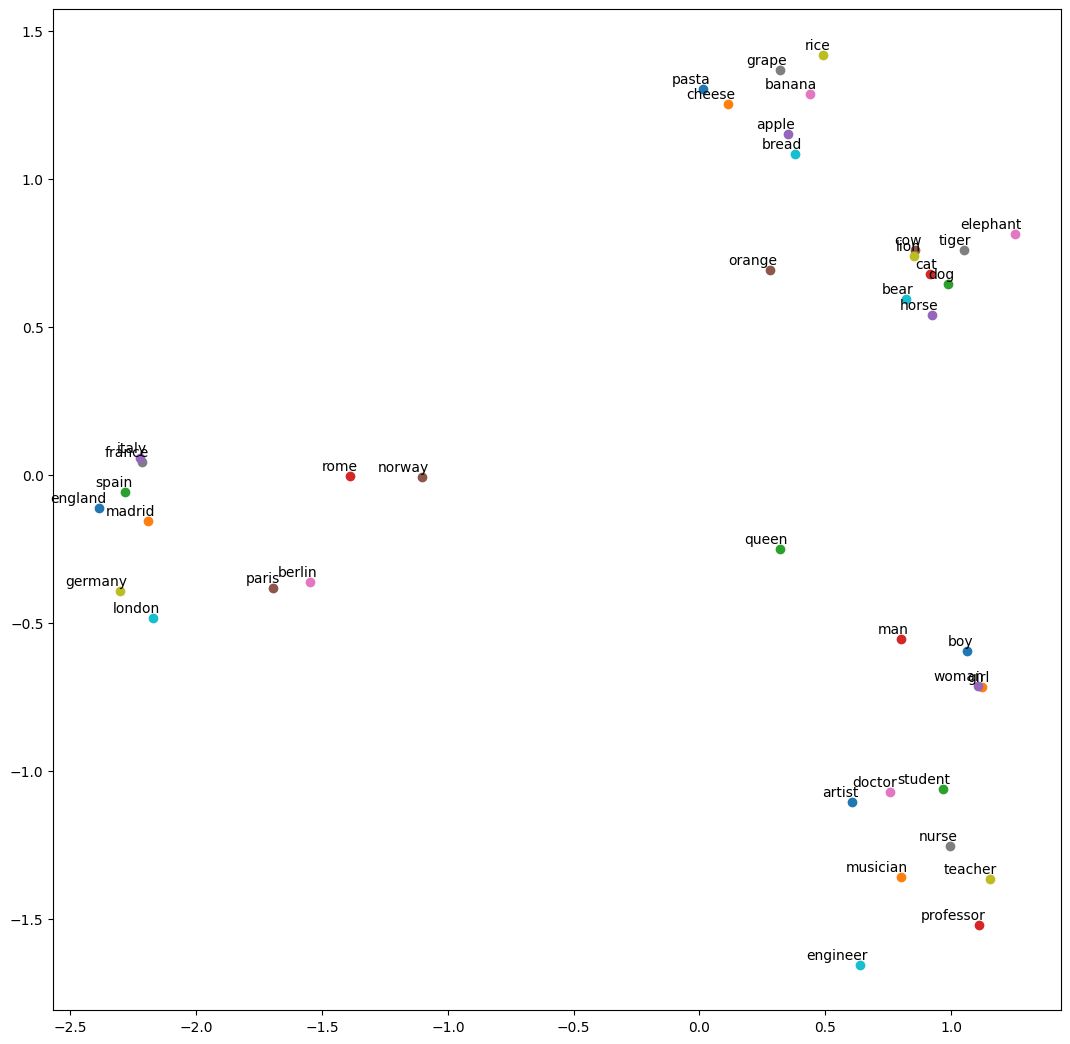

In [14]:
# Word2Vec 임베딩 시각화
plot_embeddings(word2vec_model, word_list)

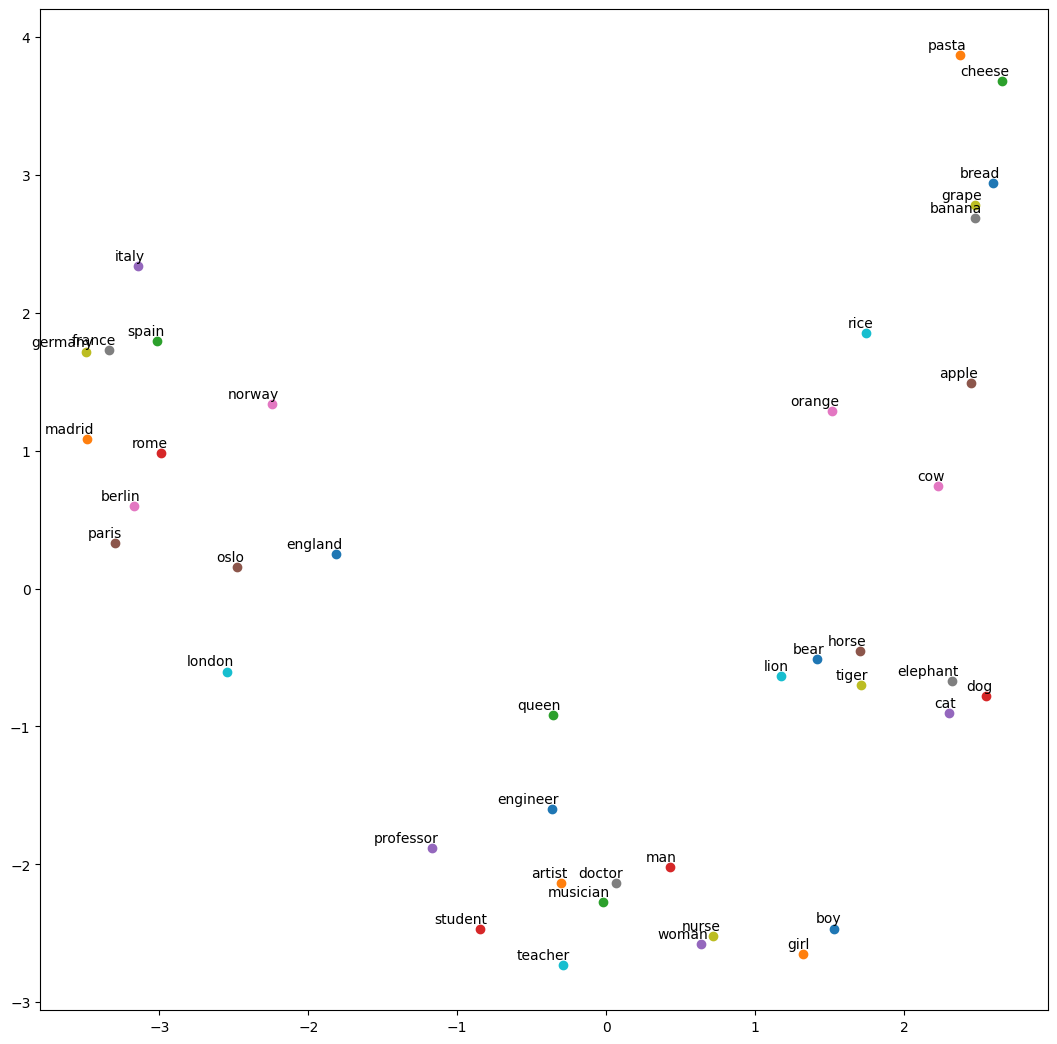

In [15]:
# GloVe 임베딩 시각화
plot_embeddings(glove_model, word_list)

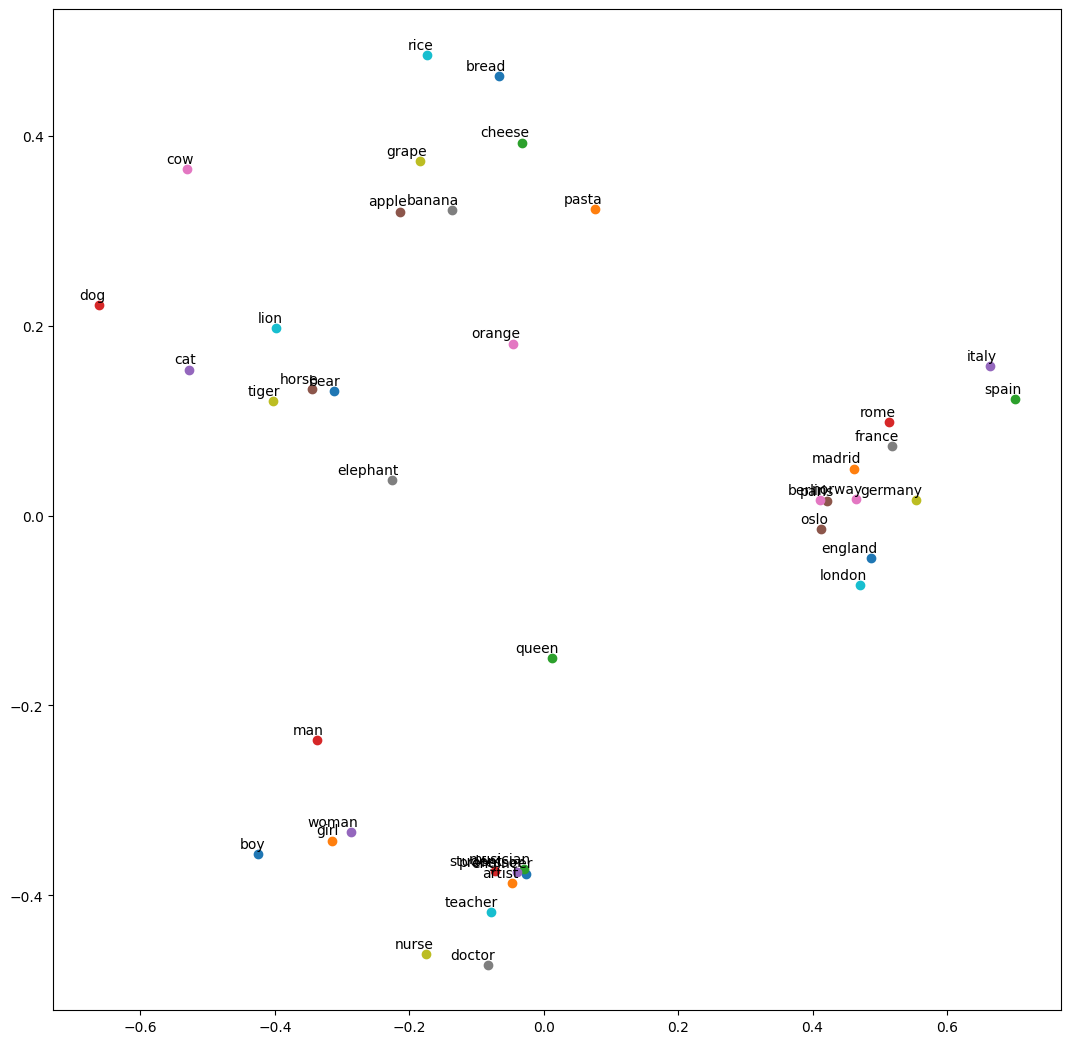

In [16]:
# FastText 임베딩 시각화
plot_embeddings(fasttext_model, word_list)

## 벡터 연산 시각화

임베딩 모델에서 벡터 연산을 통해 얻은 결과를 시각화하여, 모델이 단어 간 의미적 관계를 어떻게 학습하는지 살펴보겠습니다. 'king'에서 'man'을 뺀 벡터와 'queen'에서 'woman'을 뺀 벡터를 PCA를 사용하여 2차원으로 시각화합니다.

In [17]:
# 두 벡터 간의 차이를 plot 하는 함수 정의
def plot_vector_operations(embedding_model, word1_2, word3_4, word5_6, word7_8):
    # 벡터 차 연산
    try:
        vector1 = embedding_model[word1_2[0]] - embedding_model[word1_2[1]]  # 첫 번째 단어 쌍의 벡터 차 연산 수행
        vector2 = embedding_model[word3_4[0]] - embedding_model[word3_4[1]]  # 두 번째 단어 쌍의 벡터 차 연산 수행
        vector3 = embedding_model[word5_6[0]] - embedding_model[word5_6[1]]  # 세 번째 단어 쌍의 벡터 차 연산 수행
        vector4 = embedding_model[word7_8[0]] - embedding_model[word7_8[1]]  # 네 번째 단어 쌍의 벡터 차 연산 수행

    except KeyError as e:
        print(f"Error: {e}")  # 모델에 없는 단어가 있을 경우 오류 메시지 출력
        return

    # PCA를 사용하여 2차원으로 축소
    pca_model = PCA(n_components=2)
    word_vectors = np.array([vector1, vector2, vector3, vector4])  # 연산된 벡터들을 배열로 만듦
    word_labels = [f"{word1_2[0]}-{word1_2[1]}", f"{word3_4[0]}-{word3_4[1]}", f"{word5_6[0]}-{word5_6[1]}", f"{word7_8[0]}-{word7_8[1]}"]  # 벡터 연산에 사용된 단어 쌍을 레이블로 만듦
    reduced_vectors = pca_model.fit_transform(word_vectors)  # 벡터들을 2차원으로 축소

    # 시각화
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(word_labels):
        x, y = reduced_vectors[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(30, 4), textcoords='offset points', ha='right', va='bottom')
    plt.show()

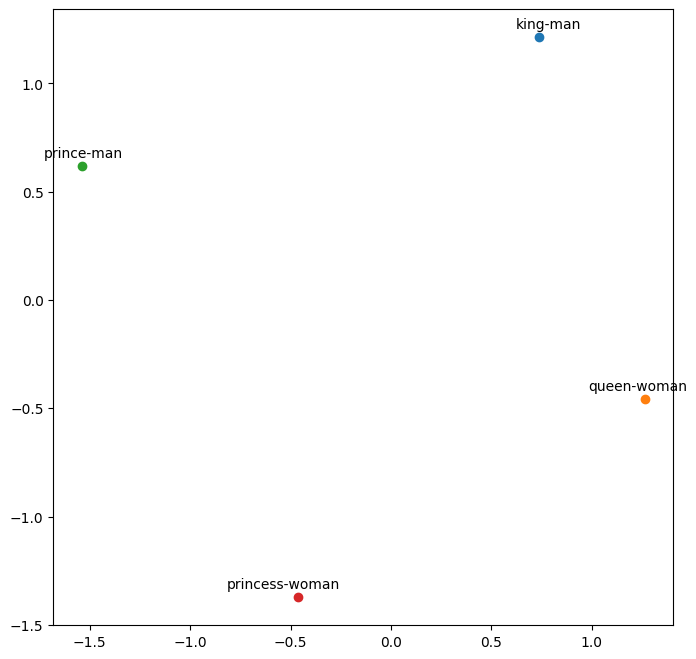

In [18]:
# 벡터 연산 시각화
plot_vector_operations(word2vec_model, ['king', 'man'], ['queen', 'woman'], ['prince', 'man'], ['princess', 'woman'])

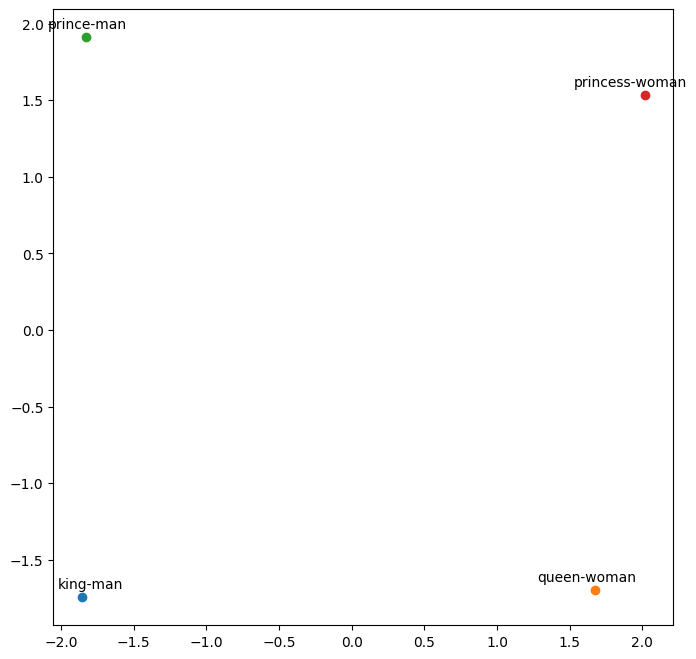

In [19]:
plot_vector_operations(glove_model, ['king', 'man'], ['queen', 'woman'], ['prince', 'man'], ['princess', 'woman'])

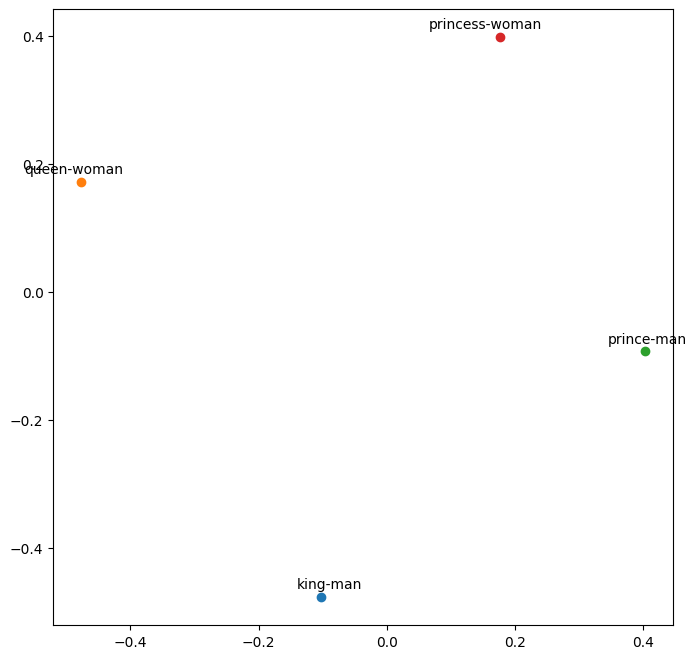

In [20]:
plot_vector_operations(fasttext_model, ['king', 'man'], ['queen', 'woman'], ['prince', 'man'], ['princess', 'woman'])

## 각 사전학습 임베딩 모델을 통한 감성분석 Task 수행
Word2Vec, FastText, Glove 모델로 감성분석 Task를 수행해봅시다

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText as FT_gensim
import numpy as np

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

In [25]:
# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


###  데이터셋 개요 </b>

* 데이터셋: IMDB Movie Review Dataset
* 데이터셋 개요: 인터넷 영화 데이터베이스(IMDB)에서 수집한 영어 영화 리뷰 데이터셋입니다. 총 50,000개의 데이터로 구성되어 있으며, 각 리뷰는 긍정적인 리뷰와 부정적인 리뷰로 나뉘어져 있습니다. 데이터셋은 훈련용과 테스트용으로 나뉘어져 있으며, 각각 25,000개의 리뷰를 포함하고 있습니다.
* 데이터셋 저작권: CC-BY-SA




In [26]:
# 데이터셋 로드
# 아래의 작업은 train set과 test set의 label (0, 1) 분포를 정확히 50%:50%로 나누기 위함임

# 데이터셋 로드 및 셔플
dataset = load_dataset('imdb').shuffle(seed=42)

# 라벨별로 데이터셋 분할
train_dataset_pos = dataset['train'].filter(lambda example: example['label'] == 1).select(range(6000)) # 라벨이 1인 데이터 6000개 샘플링하여 train set에 추가
train_dataset_neg = dataset['train'].filter(lambda example: example['label'] == 0).select(range(6000)) # 라벨이 0인 데이터 6000개 샘플링하여 train set에 추가
test_dataset = dataset['test'].shuffle(seed=42).select(range(1000))

# 라벨별 데이터셋 합치기
train_dataset = concatenate_datasets([train_dataset_pos, train_dataset_neg])

Filter: 100%|██████████| 25000/25000 [00:00<00:00, 131731.65 examples/s]


In [27]:
# 임베딩을 위한 함수 정의
def get_embedding(word, embedding_model):
    try:
        return embedding_model[word]  # 주어진 단어의 임베딩을 return
    except KeyError:
        return np.zeros(embedding_model.vector_size)  # 단어가 임베딩 모델에 없는 경우, 0으로 채워진 벡터 return

# 단어 시퀀스를 임베딩 벡터 시퀀스로 변환
def get_embeddings_for_sequence(sequence_list, embedding_model):
    embeddings_batch = []
    for sequence in sequence_list:
        embeddings = [get_embedding(word, embedding_model) for word in sequence.split()]  # 시퀀스 내의 각 단어에 대해 임베딩을 가져옮
        embeddings_batch.append(embeddings) # 배치에 추가
    embeddings_batch = torch.nn.utils.rnn.pad_sequence([torch.tensor(embedding, dtype=torch.float) for embedding in embeddings_batch], batch_first=True)  # 배치 내의 모든 시퀀스를 동일한 길이로 padding
    return embeddings_batch


# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        # 임베딩 층은 사전 훈련된 임베딩을 사용하므로 정의하지 않음 !
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True) # LSTM 초기화
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim) # 최종 분류기 초기화
        self.dropout = nn.Dropout(dropout) # 드롭아웃 초기화

    def forward(self, text_embedding):
        embedded = self.dropout(text_embedding)  # 드롭아웃 적용
        lstm_output, (hidden, cell) = self.lstm(embedded)  # LSTM 층 통과
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))  # 양방향 LSTM의 경우, 두 방향의 마지막 hidden state를 concatenate
        else:
            hidden = self.dropout(hidden[-1,:,:])  # 단방향 LSTM의 경우, last hidden state만 사용
        return self.fc(hidden.squeeze(0))  # 최종 분류기층 통과하여 최종 출력 return


# 학습 함수 정의
def train(model, train_loader, optimizer, criterion, embedding_model):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0
    for batch in tqdm(train_loader, total=len(train_loader), desc='Training...'):
        optimizer.zero_grad()  # 옵티마이저 그래디언트를 초기화
        text, label = batch['text'], batch['label']
        text_embedding = get_embeddings_for_sequence(text, embedding_model).to(device)  # 텍스트를 임베딩으로 변환하고 GPU로 이동
        label = label.to(device)  # 레이블도 GPU로 이동
        predictions = model(text_embedding).squeeze(1)  # 모델을 통해 예측 수행
        loss = criterion(predictions, label.float())  # loss 계산
        loss.backward()  # backpropagation 수행
        optimizer.step()  # 가중치 업데이트
        total_loss += loss.item()
    return total_loss / len(train_loader)  # epoch의 평균 loss를 return

# 평가 함수 정의
def evaluate(model, test_loader, criterion, embedding_model):
    model.eval() # 모델을 평가모드로 전환 (dropout 수행하지 않음)
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad(): # gradient 누적 비활성화
        for batch in tqdm(test_loader, total=len(test_loader), desc='Evaluating...'):
            text, label = batch['text'], batch['label']
            text_embedding = get_embeddings_for_sequence(text, embedding_model).to(device)
            label = label.to(device)
            predictions = model(text_embedding).squeeze(1)
            loss = criterion(predictions, label.float())
            total_loss += loss.item()

            # 예측값을 이진 분류 결과로 변환
            preds = torch.round(torch.sigmoid(predictions))
            all_predictions.extend(preds.cpu().numpy().astype(int)) # 모델의 예측 저장
            all_labels.extend(label.cpu().numpy()) # 실제 정답 저장

    # 정확도와 F1 점수 계산
    accuracy = accuracy_score(all_labels, all_predictions) # accuracy 계산

    return total_loss / len(test_loader), accuracy

In [28]:
hidden_dim = 256 # LSTM hidden 차원
output_dim = 1 # 출력 차원 (긍정/부정)
n_layers = 4 # LSTM 층의 수
bidirectional = True # 양방향 LSTM
dropout = 0.25 # 드롭아웃 비율

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


# 학습 및 평가
embedding_models = {
    'word2vec': word2vec_model,
    'glove': glove_model,
    'fasttext': fasttext_model
}

for embedding_name, embedding_model in embedding_models.items():
  print('----' * 7 + f' {embedding_name} ' + '----' * 7)
  model = LSTM(
      embedding_dim=embedding_model.vector_size,
      hidden_dim=hidden_dim,
      output_dim=output_dim,
      n_layers=n_layers,
      bidirectional=bidirectional,
      dropout=dropout
  ).to(device) # 모델 초기화 및 GPU로 이동

  optimizer = torch.optim.Adam(model.parameters()) # 옵티마이저 초기화 (Adam)
  criterion = nn.BCEWithLogitsLoss().to(device) # Loss 정의 및 GPU로 이동

  # 학습 및 평가 루프
  for epoch in range(5):  # 에포크 설정
    train_loss = train(model, train_loader, optimizer, criterion, embedding_model) # 학습
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, embedding_model) # 평가
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    print('----' * 20)

---------------------------- word2vec ----------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Epoch: 1, Train Loss: 0.6807, Test Loss: 0.6929, Test Accuracy: 0.5170
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Epoch: 2, Train Loss: 0.6939, Test Loss: 0.6948, Test Accuracy: 0.4830
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Epoch: 3, Train Loss: 0.6835, Test Loss: 0.6954, Test Accuracy: 0.5170
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Epoch: 4, Train Loss: 0.6831, Test Loss: 0.6794, Test Accuracy: 0.5700
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Epoch: 5, Train Loss: 0.6722, Test Loss: 0.6869, Test Accuracy: 0.5330
--------------------------------------------------------------------------------
---------------------------- glove ----------------------------


Evaluating...: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


Epoch: 1, Train Loss: 0.6863, Test Loss: 0.6700, Test Accuracy: 0.6090
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


Epoch: 2, Train Loss: 0.6923, Test Loss: 0.6963, Test Accuracy: 0.4840
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


Epoch: 3, Train Loss: 0.6938, Test Loss: 0.6865, Test Accuracy: 0.5170
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:05<00:00,  5.49it/s]


Epoch: 4, Train Loss: 0.6929, Test Loss: 0.6923, Test Accuracy: 0.5160
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


Epoch: 5, Train Loss: 0.6935, Test Loss: 0.6928, Test Accuracy: 0.5160
--------------------------------------------------------------------------------
---------------------------- fasttext ----------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Epoch: 1, Train Loss: 0.6848, Test Loss: 0.6926, Test Accuracy: 0.5180
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Epoch: 2, Train Loss: 0.6951, Test Loss: 0.6922, Test Accuracy: 0.5160
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Epoch: 3, Train Loss: 0.6951, Test Loss: 0.7001, Test Accuracy: 0.4830
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Epoch: 4, Train Loss: 0.6947, Test Loss: 0.6931, Test Accuracy: 0.5170
--------------------------------------------------------------------------------


Evaluating...: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]

Epoch: 5, Train Loss: 0.6945, Test Loss: 0.6940, Test Accuracy: 0.4830
--------------------------------------------------------------------------------


## Required Package

transformers>=4.2.1 <br>
pytorch>=1.7.1 <br>
pandas==1.5.3 <br>
numpy>=1.19.2 <br>
datasets==2.16.1 <br>
gensim==4.3.2 <br>
matplotlib==3.7.1 <br>
scikit-learn==1.2.2 <br>
</font>

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 업스테이지, 패스트캠퍼스에에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.**